# This notebook demonstrates some example imagingDB usecases

First, we need to connect to thte database using a JSON file containing database login information

In [5]:
import importlib

import imaging_db.database.db_session as db_session

# Import all our tables
from imaging_db.database.base import Base
from imaging_db.database.file_global import FileGlobal
from imaging_db.database.sliced_global import SlicedGlobal
from imaging_db.database.slices import Slices
# This is the overall table containing the identifier and description
from imaging_db.database.project import Project


importlib.reload(db_session)
credentials_filename = "/Users/jenny.folkesson/Code/db_credentials.json"

Now we can run some queries. Let's start with listing the names of existing tables

In [6]:
with db_session.session_scope(credentials_filename) as session:
    print(Base.metadata.tables.keys())

dict_keys(['file_global', 'sliced_global', 'slices', 'project'])


The main table "Project" contains the unique identifier, a description, and it's also telling us if the file as been slices or uploaded "as is".

In [7]:
# Print all existing projects with their properties
projs = session.query(Project)
for p in projs:
    print(p.id)
    print(p.project_serial)
    print("Description:", p.description)
    print("Has this file been sliced:", p.sliced)
    print("--------")

1
ML-2018-04-05-08-55-00-0001
Description: This is a blank slide for testing
Has this file been sliced: False
--------
2
ISP-2018-06-08-15-45-00-0001
Description: This is what I assume is a typical ome-tif file
Has this file been sliced: True
--------


Next, let's print all the fields for all files in FileGlobal.
FileGlobal is the class which contains files that have been uploaded as is to S3.

In [8]:
files = session.query(FileGlobal)
for f in files:
    # This table has a one to one mapping with Project so we can retrieve ID
    print(f.project.project_serial)
    print("Folder location in S3 bucket:", f.folder_name)
    print(f.metadata_json)
    print("--------")

ML-2018-04-05-08-55-00-0001
Folder location in S3 bucket: raw_files/ML-2018-04-05-08-55-00-0001
{'file_origin': '/Users/jenny.folkesson/Data/microscopy/BlankSlide_DAPI_TxRed_BF_Phase.lif'}
--------


SlicedGlobal contains global information for a particular file that has been sliced:

In [9]:
sliced = session.query(SlicedGlobal)
for s in sliced:
    print("Number of frames:", s.nbr_frames)
    print("Image width:", s.im_width)
    print("Image height:", s.im_height)
    print("Bit depth:", s.bit_depth)
    print("Folder in S3 bucket:", s.folder_name)
    # This table has a one to one mapping with Project so we can retrieve ID
    print("Unique ID:", s.project.project_serial)
    print("Global metadata:", s.metadata_json)
    print("--------")

Number of frames: 39
Image width: 2048
Image height: 2048
Bit depth: uint16
Folder in S3 bucket: raw_slices/ISP-2018-06-08-15-45-00-0001
Unique ID: ISP-2018-06-08-15-45-00-0001
Global metadata: {'IJMetadata': {'ROI': [0, 0, 2048, 2048], 'UUID': '2e39c52a-6055-4579-8b2e-ff8ead0b3848', 'Depth': 2, 'Width': 2048, 'Frames': 1, 'Height': 2048, 'IJType': 1, 'Prefix': 'ISP_293T_TFRC_sgRNA2_20180601_1', 'Slices': 13, 'Source': 'Micro-Manager', 'ChNames': ['DAPI', 'FITC', 'Cy3'], 'Comment': '', 'GridRow': 0, 'BitDepth': 16, 'ChColors': [-10066177, -13421569, -205], 'Channels': 3, 'UserName': 'insituscope', 'Directory': 'C:\\Users\\InSituScope\\Desktop\\ISP-2018-06-01-001', 'PixelType': 'GRAY16', 'Positions': 6, 'TimeFirst': False, 'z-step_um': 0.7999999999999998, 'GridColumn': 0, 'Interval_ms': 0, 'PixelAspect': 1, 'SlicesFirst': True, 'ComputerName': 'BioEInSituTranscript1', 'PixelSize_um': 0, 'CameraTimeout': 20000, 'ChContrastMax': [65536, 65536, 65536], 'ChContrastMin': [0, 0, 0], 'Metadata

The next table for sliced data is "Slices", which contains slice specific information.
This table has a many to one mapping with *SlicedGlobal*.

In [10]:
slice_info = session.query(Slices)
for i in slice_info:
    print(i.id)
    print("Channel index:", i.channel_idx)
    print("Slice index:", i.slice_idx)
    print("Frame index:", i.frame_idx)
    print("Exposure (ms):", i.exposure_ms)
    print("Channel name:", i.channel_name)
    print("File name:", i.file_name)
    # Since Slices has a many to one mapping to SlicedGlobal, we can easily retrieve info from there
    print("Total number of frames in file:", i.sliced_global.nbr_frames)
    # SlicedGlobal in turn has a one to one mapping to Project, so from a Slice we can get project info:
    print("Project ID:", i.sliced_global.project.project_serial)
    print("------------------------------------")

1
Channel index: 0
Slice index: 0
Frame index: 0
Exposure (ms): 50
Channel name: DAPI
File name: im_c000_z000_t000.png
Total number of frames in file: 39
Project ID: ISP-2018-06-08-15-45-00-0001
------------------------------------
2
Channel index: 0
Slice index: 1
Frame index: 0
Exposure (ms): 50
Channel name: DAPI
File name: im_c000_z001_t000.png
Total number of frames in file: 39
Project ID: ISP-2018-06-08-15-45-00-0001
------------------------------------
3
Channel index: 0
Slice index: 2
Frame index: 0
Exposure (ms): 50
Channel name: DAPI
File name: im_c000_z002_t000.png
Total number of frames in file: 39
Project ID: ISP-2018-06-08-15-45-00-0001
------------------------------------
4
Channel index: 0
Slice index: 3
Frame index: 0
Exposure (ms): 50
Channel name: DAPI
File name: im_c000_z003_t000.png
Total number of frames in file: 39
Project ID: ISP-2018-06-08-15-45-00-0001
------------------------------------
5
Channel index: 0
Slice index: 4
Frame index: 0
Exposure (ms): 50
Chann

Some other examples of queries:
Find all Projects which have been sliced

In [12]:
projs = session.query(Project).filter(Project.sliced == True).all()
for p in projs:
    print(p.id)
    print(p.project_serial)
    print("Description:", p.description)
    print("Is it sliced:", p.sliced)
    print("--------")

2
ISP-2018-06-08-15-45-00-0001
Description: This is what I assume is a typical ome-tif file
Is it sliced: True
--------


Get all unique channel names for sliced data:

In [13]:
for value in session.query(Slices.channel_name).distinct():
    print(value)

('DAPI',)
('FITC',)
('Cy3',)


Now let's get into joint queries. 

A typical usecase would be to get the S3 storage paths for all slices from a known Project ID.
In this example we only want to retrieve the files from a specific channel named FITC.

We can get this information by joining tables Sliced, SlicedGlobal, and Project

In [24]:
project_identifier = "ISP-2018-06-08-15-45-00-0001"
channel_name = "FITC"

all_slices = session.query(Slices, SlicedGlobal, Project) \
    .join(SlicedGlobal) \
    .join(Project) \
    .filter(Project.project_serial == project_identifier) \
    .filter(Slices.channel_name == channel_name) \
    .all()

folder_name = all_slices[0][0].sliced_global.folder_name
print(folder_name)
stack_shape = (
    all_slices[0][0].sliced_global.im_width,
    all_slices[0][0].sliced_global.im_height,
    len(all_slices),
)
print("Stack shape:", stack_shape)
bit_depth = all_slices[0][0].sliced_global.bit_depth
print("Bit depth:", bit_depth)
file_names = []
for s in all_slices:
    file_names.append(s[0].file_name)
    print(s[0].file_name)

raw_slices/ISP-2018-06-08-15-45-00-0001
Stack shape: (2048, 2048, 13)
Bit depth: uint16
im_c001_z000_t000.png
im_c001_z001_t000.png
im_c001_z002_t000.png
im_c001_z003_t000.png
im_c001_z004_t000.png
im_c001_z005_t000.png
im_c001_z006_t000.png
im_c001_z007_t000.png
im_c001_z008_t000.png
im_c001_z009_t000.png
im_c001_z010_t000.png
im_c001_z011_t000.png
im_c001_z012_t000.png


Now we can fetch that data from the S3 bucket where they're stored.

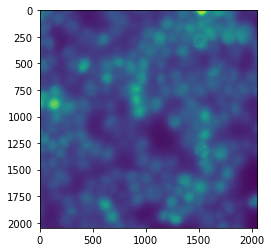

In [20]:
%matplotlib inline
import imaging_db.filestorage.s3_uploader as s3_uploader
import matplotlib.pyplot as plt

importlib.reload(s3_uploader)
data_uploader = s3_uploader.DataUploader(folder_name=folder_name)
im_stack = data_uploader.fetch_slices(file_names, stack_shape, bit_depth)
plt.imshow(im_stack[..., 0])
plt.show()

In [21]:
print(im_stack.shape)
print(im_stack.dtype)
print(im_stack.max(), im_stack.min())

(2048, 2048, 13)
float64
24506.0 272.0


In [25]:
session.rollback()
session.close()